In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms {manual_transforms}")

Manually created transforms Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7794a7b16860>,
 ['pizza', 'steak', 'sushi'])

In [7]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

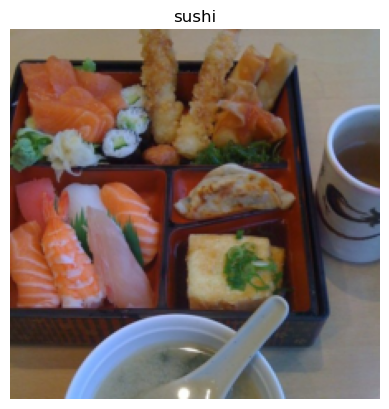

In [8]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [9]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [10]:
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


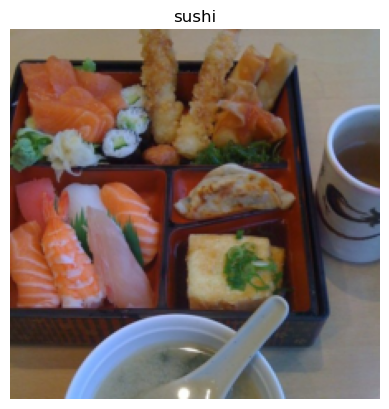

In [11]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

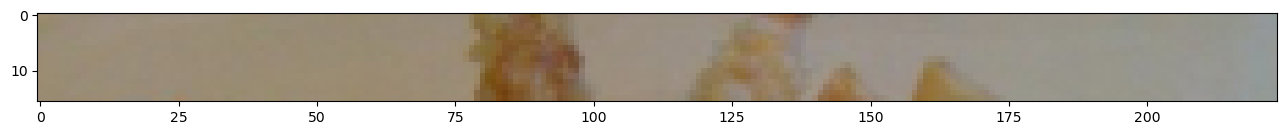

In [12]:
image_permuted = image.permute(1, 2, 0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


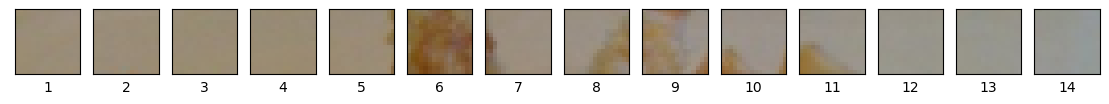

In [13]:
img_size = 224
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); 
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


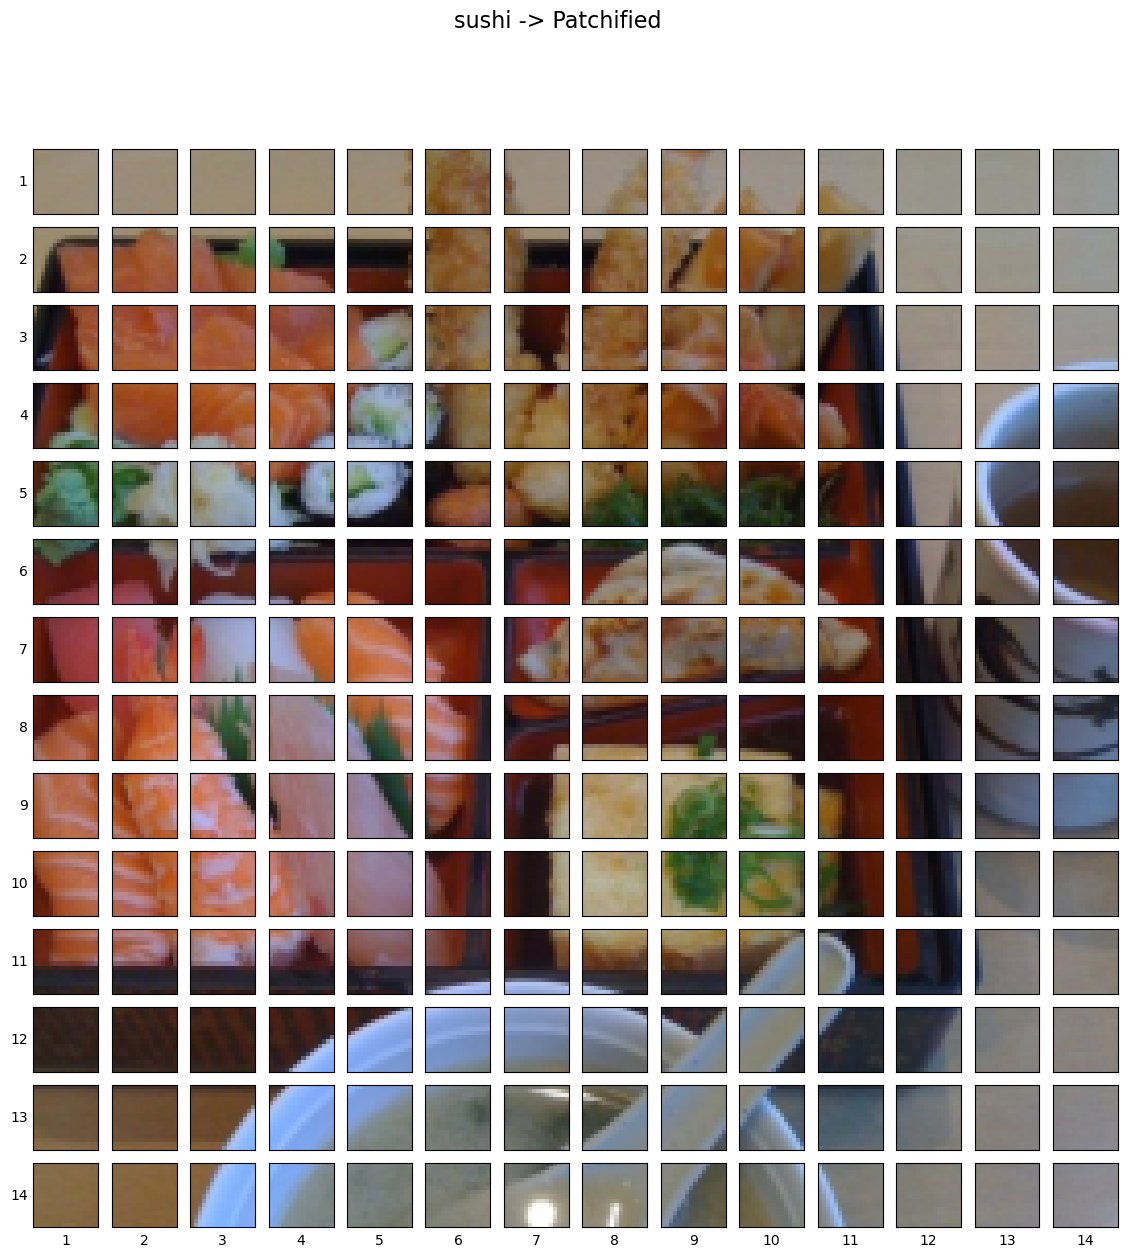

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])

        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [19]:
patch_size=16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

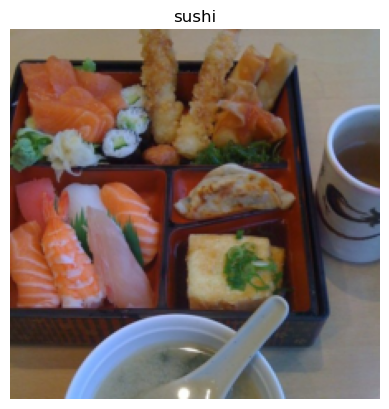

In [20]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [21]:
image_out_of_conv = conv2d(image.unsqueeze(0)) 
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [22]:
flatten = nn.Flatten(start_dim=2, end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


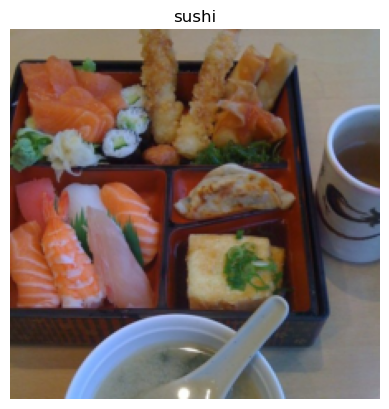

In [23]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [24]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


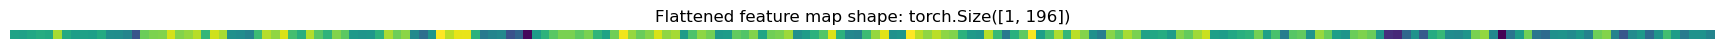

In [25]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [26]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        return self.flatten(self.patcher(x)).permute(0, 2, 1)